In [20]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.plotly as py
#import datetime
import time
#import math
import pyodbc
sns.set_style("whitegrid")

In [45]:
taglistfile = 'C:\\Users\meclijda\Documents\TagList.csv'
dfTags = pd.read_csv(taglistfile,";",encoding = "ISO-8859-1")
tagList = dfTags['Tag'].tolist()
print(str(len(tagList))+ ' tags in the taglist')
#print(dfTags['Tag'].head())
#print(list(set([x for x in tagList if tagList.count(x) > 1])))

62 tags in the taglist


In [4]:
%timeit
# read IP21 tag data
strAsOfDate = '24-AUG-15 11:40:00.0'
strUpToDate = '28-DEC-16 00:00:00.0'
pattern = '%d-%b-%y %H:%M:%S.0'
#epochstart = int(time.mktime(time.strptime(strAsOfDate, pattern)))

start_time = time.time()

strConnect = 'DSN=PO_ODBC'
cnn = pyodbc.connect(strConnect)

#print(tagList[0])
df = pd.DataFrame()
for i, strTagName in enumerate(tagList):
    print(str(i) + ': Main tag characteristics of ' + strTagName)
    sql = "select TS_START, AVG from aggregates "\
        "where name = '" + strTagName + "' "\
        "and TS between '" + strAsOfDate + "' and '" + strUpToDate + "' "\
        "and period = 1:00;"
    #print(sql)
    data1 = pd.read_sql(sql, cnn)
    data1['TS_START'] = pd.to_datetime(data1['TS_START'],utc=True)
    #data1['TS_START'] = data1['TS_START'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
    data1.set_index('TS_START',inplace=True)
    data1.columns = [strTagName]
    #data1.to_csv(strTagName.replace(":","_") + '.csv')
    #data2 = data1.resample('1H', how='mean')
    print(data1.describe(percentiles=[]))
    df = pd.concat([df, data1], axis=1)

cnn.close
elapsed_time = time.time() - start_time
print(elapsed_time)
#print(df.describe())

0: Main tag characteristics of POARFQCA-17901:me
       POARFQCA-17901:me
count       11677.000000
mean           23.833467
std             2.718410
min             0.000000
25%            23.345862
50%            24.702696
75%            25.440936
max            28.705033
1: Main tag characteristics of POARAIA-17903_1a:av
       POARAIA-17903_1a:av
count         11677.000000
mean             66.930891
std              17.908767
min               0.000000
25%              69.536241
50%              71.251363
75%              73.355168
max             101.610271
2: Main tag characteristics of POARAIA-17903_3a:av
       POARAIA-17903_3a:av
count         11677.000000
mean             63.957034
std              17.375770
min               0.000000
25%              65.729877
50%              69.043647
75%              70.874566
max              78.515004
3: Main tag characteristics of POARTC-17902:me
       POARTC-17902:me
count     11677.000000
mean         95.081252
std           3.578296

#### create filter for steady state
* POARFQCA-17901:me (C6-feed t/h) * POARAIA-17903_1a:av (DA901 Feed C6H6 p-%) >= 15t/h

In [37]:
df_filter = pd.DataFrame()
df['BzFeed'] = df['POARFQCA-17901:me']*df['POARAIA-17903_1a:av']/100
df_filter['Filter_BzFeed_gt15'] = df['BzFeed']>=14.95
print(df_filter['Filter_BzFeed_gt15'].describe())

count     11677
unique        2
top        True
freq       9756
Name: Filter_BzFeed_gt15, dtype: object


<IPython.core.display.Javascript object>


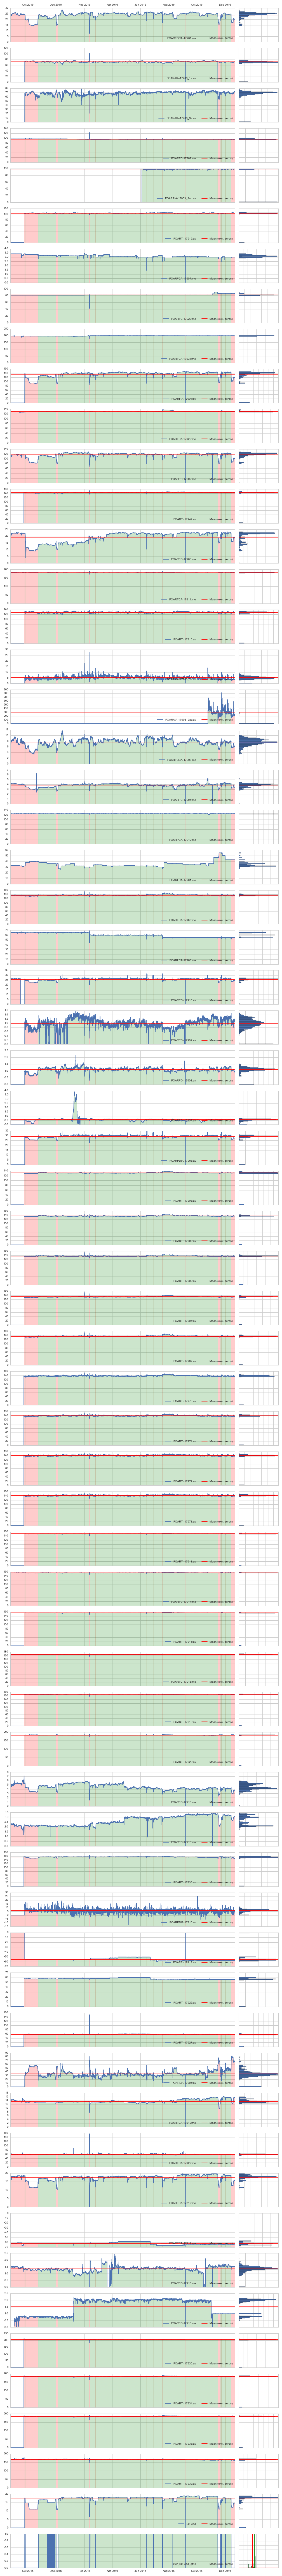

In [41]:
def plottimeseries(df):
    numSubPlots = len(df.columns)
    f, axarr = plt.subplots(nrows=numSubPlots, ncols=2, figsize=(14,numSubPlots*2), gridspec_kw = {'width_ratios':[17, 3]})
    for i, tag in enumerate(df.columns):
        axarr[i,0].plot(df.index, df[tag])
        axarr[i,0].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        #axarr[i].axhline(y = df[tag][df[tag]!=0].median(), color = 'g',label='Median excluding zeros')
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter['Filter_BzFeed_gt15']==False,color='r',alpha=0.2)
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter['Filter_BzFeed_gt15']==True,color='g',alpha=0.2)
        axarr[i,0].legend(loc='lower right',ncol=2)
        if (i!=numSubPlots-1 and i!=0):
            axarr[i,0].xaxis.set_ticklabels([])
        if i==0:
            axarr[i,0].xaxis.tick_top()
        axarr[i,1].hist(df[tag],bins=50,normed=True,orientation='horizontal')
        axarr[i,1].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        axarr[i,1].xaxis.set_ticklabels([])
        axarr[i,1].yaxis.set_ticklabels([])
    plt.tight_layout()
        
#plottimeseries(df[df.columns[:10]|['Filter_BzFeed_gt15']])
plottimeseries(df)

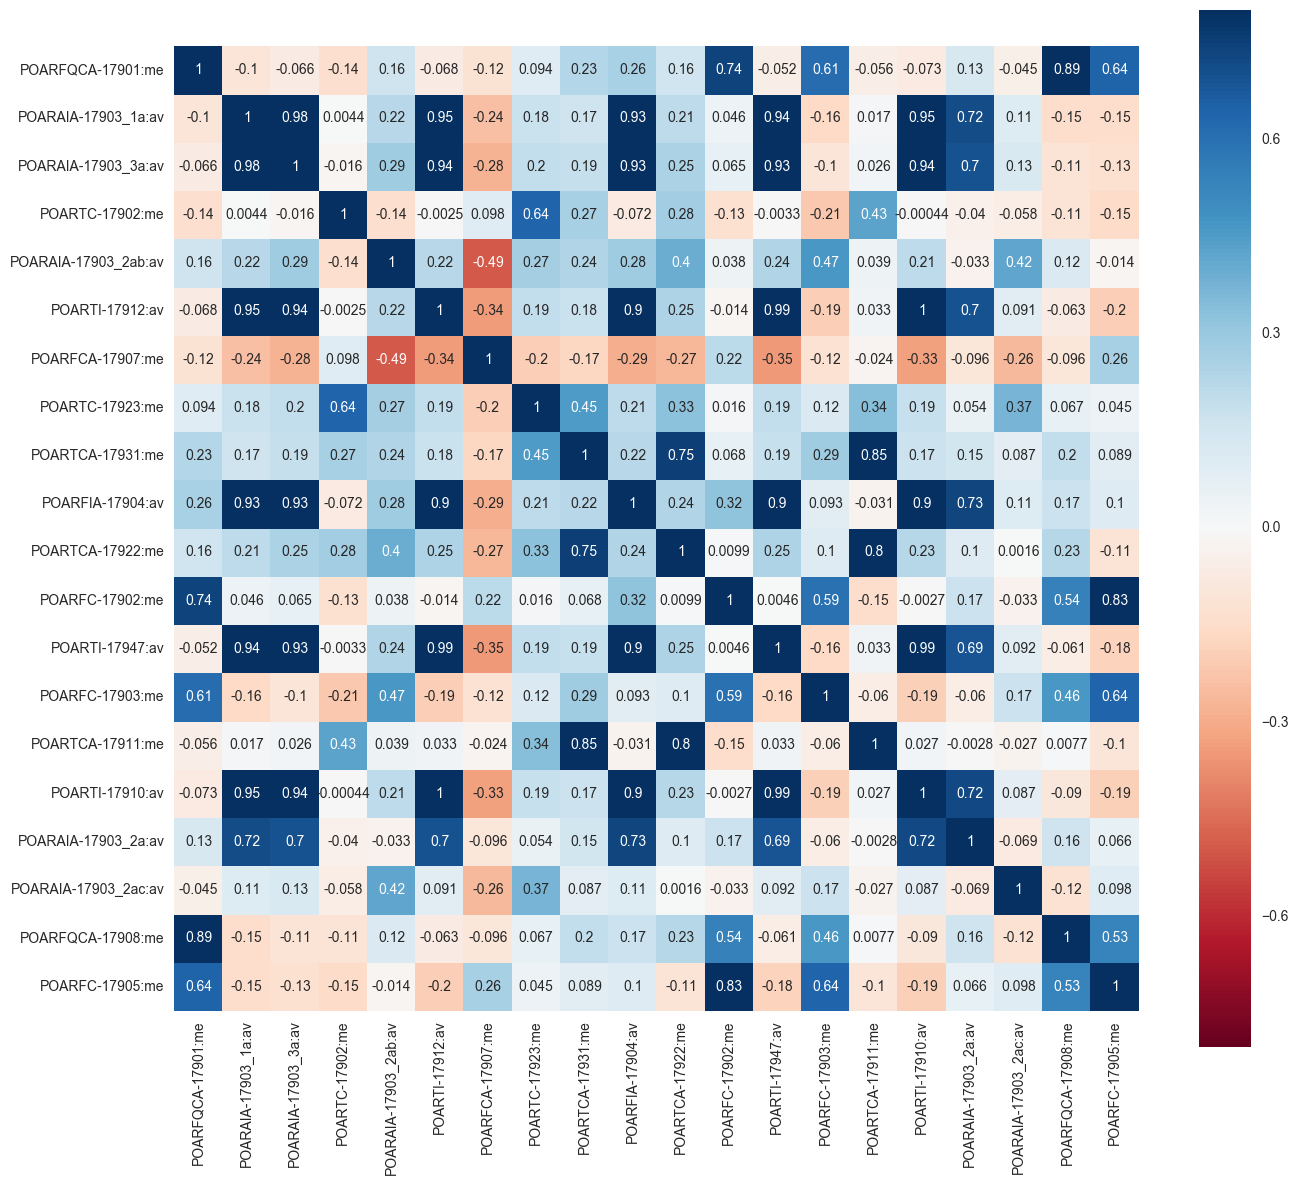

In [17]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corrmat.ix[:20, :20], vmax=.8, square=True, yticklabels=True, annot=True,cmap="RdBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

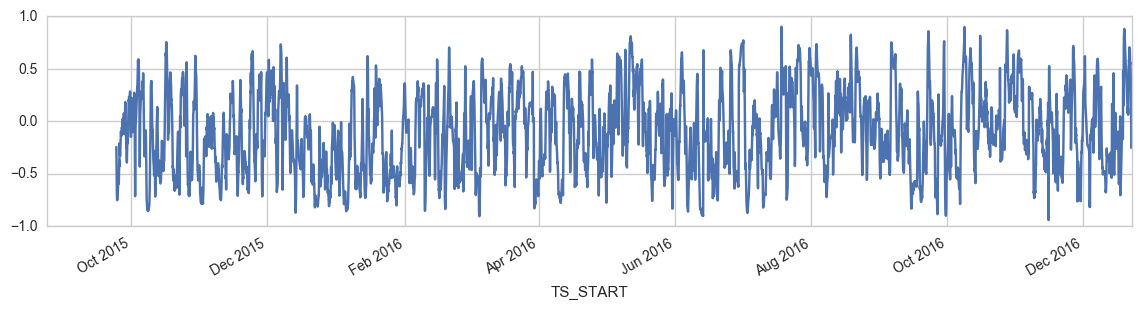

POARFQCA-17901:me - POARAIA-17903_2a:av


In [8]:
correls = df.rolling(window=50).corr()
plt.figure(figsize=(14,3))
correls.loc[:, df.columns[0], df.columns[16]].plot()
plt.show()
print(df.columns[0] + " - " + df.columns[16])

<IPython.core.display.Javascript object>


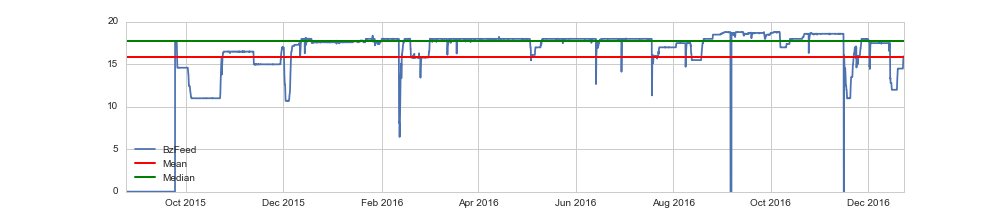

In [30]:
strTagName='BzFeed'
plt.figure(figsize=(12,3))
plt.plot(df.index,df[strTagName],label=strTagName)
plt.axhline(y = df[strTagName].mean(), linewidth=2, color = 'r',label='Mean')
plt.axhline(y = df[strTagName].median(), linewidth=2, color = 'g',label='Median')
plt.legend(loc='lower left')
plt.show()
#py.iplot_mpl(fig)

<IPython.core.display.Javascript object>


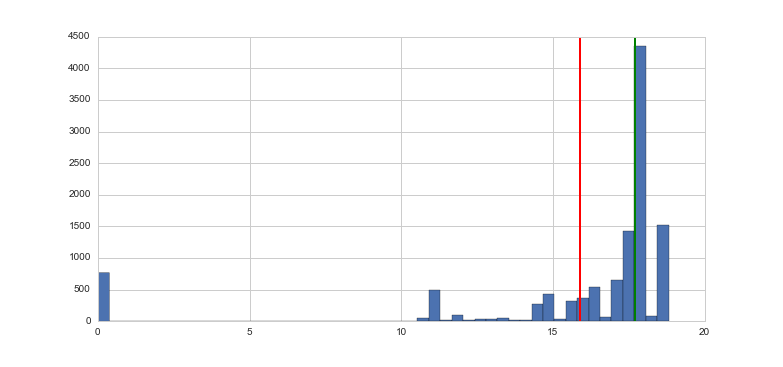

In [43]:
plt.figure(figsize=(8,5))
plt.hist(df[strTagName],50)
plt.axvline(x = df[strTagName].mean(), linewidth=2, color = 'r')
plt.axvline(x = df[strTagName].median(), linewidth=2, color = 'g')
plt.show()

In [26]:
#df['POARTI-17910:av']
#df.columns.get_loc('POARTI-17910:av')
#df.drop(df.columns[15],axis=1,inplace=True)
%matplotlib --list

Available matplotlib backends: ['qt4', 'notebook', 'nbagg', 'tk', 'gtk3', 'inline', 'osx', 'wx', 'qt', 'qt5', 'gtk']
